In [1]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

from utils import get_trajectory, get_position, my_odometry, get_interpolation, get_top_view_shape

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [4]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [6]:
env.reset()
traj = get_trajectory(env, samples=100)

/home/giulio/prog/duckrace_simulator/utils.py:188: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [7]:
traj[:10]

array([[1.47224186, 0.89882168],
       [1.46893546, 0.94380335],
       [1.46339116, 0.99298901],
       [1.46436877, 1.04217798],
       [1.46658249, 1.09136695],
       [1.4687962 , 1.14055591],
       [1.47100992, 1.18974488],
       [1.46567361, 1.22873589],
       [1.47055277, 1.27705976],
       [1.46398289, 1.3255392 ]])

In [8]:
pose = get_position(env)
pose

Position(x=0.7019999027252197, y=1.3447064071170352, theta=0)

In [9]:
from scipy import spatial

In [10]:
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])

In [11]:
traj[index]

array([0.69283913, 1.47086959])

In [12]:
top_x, top_y, z = get_top_view_shape(env)

In [43]:
inp = 0.7

splines = get_interpolation(env)
inp = (0.7)/(env.grid_width*env.road_tile_size)
out = splines[1](inp) *(env.grid_height*env.road_tile_size)/top_y

plt.scatter(*traj.T)
plt.scatter(*traj[index])
plt.scatter(pose.x, pose.y)
plt.scatter(0.7, out, c="r")

1.313918809124864

In [22]:
inp

0.39886039886039887

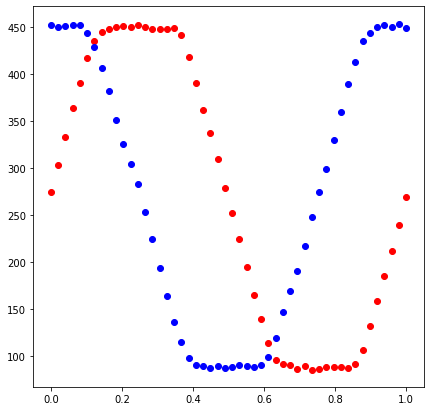

In [60]:
for i in np.linspace(0,1,50):
    plt.scatter(i, splines[1](i), c="r")
    plt.scatter(i, splines[0](i), c="b")

In [13]:
from scipy.optimize import minimize

In [14]:
def mpc_loss(u, N, x0, y0, theta0, v0, w0, closest_index, Q, R, dt, last_actions):
    """
    L(u) = sum_{t=0}^{N-1} Q * ||x_o_t - x_t||^2 + R * ||u_t||^2
    """
    u = u.reshape(-1, 2)
    u = np.concatenate((last_actions, u))
    loss = 0
    for t in range(N-1):
        p, v0, w0 = my_odometry(u[t], x0, y0, theta0, v0, w0, dt=dt)
        loss += Q[t] * ((p.x - traj[closest_index,0])**2 + (p.y - traj[closest_index,1])**2) + R * (u[t][0]**2 + u[t][1]**2)
        x0, y0, theta0 = p.x, p.y, p.theta

        # distance = ((p.x-traj[closest_index,0])**2 + (p.y-traj[closest_index,1])**2)**0.5
        # if distance < 0.01:
        #     closest_index -= 1
    return loss


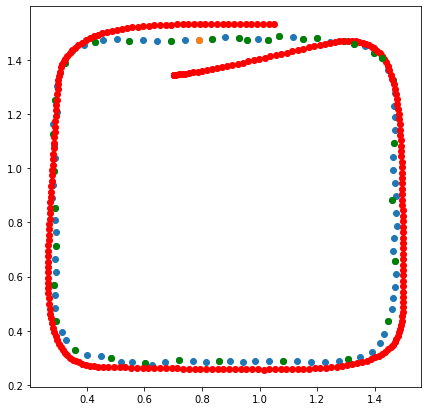

In [15]:
N = 19
Q_base = 10
Q = np.ones(N)*Q_base
# Q[:-4] = Q_base*1.3
# Q[-4:] = Q_base*1
R = 0.0

horizon_len = N*2
simulation_len = 280

delta_time = 1.0 / env.frame_rate
delay = round(0.15/delta_time)

bnds = [[-1,1]]*horizon_len

env.reset()
pose = get_position(env)
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index = index - 2
plt.scatter(*traj.T)
plt.scatter(*traj[index])

poses = [pose]
v0, w0, = 0, 0

actions = np.zeros((delay, 2))

for _ in range(simulation_len):
    u = np.ones(horizon_len)*0.5
    res = minimize(mpc_loss, u, args=(N, pose.x, pose.y, pose.theta, v0, w0, index, Q, R, delta_time, actions[-delay:]), method="L-BFGS-B", bounds=bnds, options={'maxiter': 200})
    action = res.x[:2]
    env.step(action)
    actions = np.concatenate((actions, [action]))
    pose = get_position(env)
    poses.append(pose)
    plt.scatter(pose.x, pose.y, c='r')

    distance = ((pose.x-traj[index,0])**2 + (pose.y-traj[index,1])**2)**0.5

    if pose.x > 1.2:
        Q[:-4] = Q_base
        if distance < 0.2:
            index -= 5
            plt.scatter(*traj[index], c='g')
    else:
        Q[:-4] = Q_base*1.3
        if distance < 0.29:
            index -= 3
            plt.scatter(*traj[index], c='g')

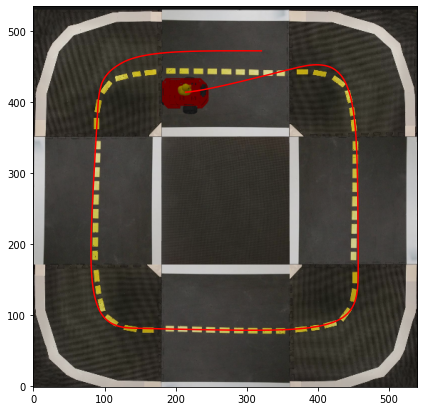

In [16]:
env.reset()
top_view = env.render(mode="top_down")[35:-30,130:-130]
plt.plot([p.x*top_view.shape[0]/(env.grid_width*env.road_tile_size) for p in poses], [p.y*top_view.shape[1]/(env.grid_width*env.road_tile_size) for p in poses], c='r')
plt.imshow(top_view, origin='lower')

In [17]:
import imageio

images = []
env.reset()
for action in actions:
    env.step(action)
    images.append(env.render(mode="rgb_array"))

imageio.mimsave("mpc_run.gif", images[::2])

In [18]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))